# This is the part of the code, where we train The Cannon

In [1]:
# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Tools
import numpy as np
import pickle
from astropy.table import Table
from astropy.io import fits
import corner
import matplotlib.pyplot as plt

# The Cannon
import thecannon as tc # see https://github.com/andycasey/AnniesLasso for more details

What do we have to do for the training?
Let's follow the description from https://annieslasso.readthedocs.io/en/latest/guide.html

In [2]:
# Let's load the matrices with fluxes and ivar
flux_ivar_file = open('training_sets/solar_twin_training_set_16xfe_snr50_flux_ivar.pickle','rb')
training_set_flux,training_set_ivar = pickle.load(flux_ivar_file)
flux_ivar_file.close()
wavelength_file = open('training_sets/solar_twin_training_set_16xfe_snr50_wavelength.pickle','rb')
wavelength_array = pickle.load(wavelength_file)
wavelength_file.close()

In [3]:
def apply_mask_censoring(wavelength_array, line_width=1.0):
    # Let's load the mask / censor matrix
    galah_dr3_lines = dict()
    galah_dr3_lines['Li'] = [6707.7635]
    galah_dr3_lines['C']  = [6587.6100]
    galah_dr3_lines['O']  = [7771.9440,7774.1660,7775.3880]
    galah_dr3_lines['Na'] = [4751.8218,5682.6333,5688.2050]
    galah_dr3_lines['Mg'] = [4730.0286,5711.0880,7691.5500,7722.5930,7759.2980]
    galah_dr3_lines['Al'] = [6696.0230,6698.6730,7835.3090,7836.1340]
    galah_dr3_lines['Si'] = [5645.6128,5665.5545,5684.4840,5690.4250,5701.1040,5772.1460,5793.0726,6583.7074,6721.8481,6741.6280,7680.2660,7688.3960,7760.6280,7799.1797,7842.9784]
    galah_dr3_lines['K']  = [5801.7490,7698.9643]
    galah_dr3_lines['Ca'] = [5857.4510,5867.5620,6471.6620,6493.7810,6499.6500,6508.8496]
    galah_dr3_lines['Sc'] = [4743.8300,4753.1610,5671.8163,5686.8386,5724.1070,5657.8960,5658.3610,5667.1490,5669.0420,5684.2020,6604.6010]
    galah_dr3_lines['Ti'] = [4722.6059,4731.1644,4733.4213,4742.1061,4742.7892,4747.6737,4758.1178,4759.2697,4778.2547,4781.7106,4797.9757,4801.9016,4805.4144,4820.4094,4848.4770,4856.0103,4870.1246,4885.0794,5689.4600,5716.4500,5720.4359,5739.4690,5823.6854,5866.4513,6554.2230,6556.0618,6599.1080,6689.2570,6716.6660,6743.1872,6745.5441,7852.6770,4719.5109,4762.7780,4764.5247,4798.5313,4849.1678,4865.6104,4874.0094]
    galah_dr3_lines['Cr'] = [4718.4190,4745.3070,4775.1300,4789.3350,4801.0247,4885.9520,5702.3060,5712.7710,5719.8150,5781.1670,5787.0210,5787.9190,5838.6690,5844.5950,6630.0100,4824.1270,4836.2290,4848.2349]
    galah_dr3_lines['Mn'] = [4739.0900,4754.0301,4761.5060,4765.8525,4766.4145,4783.4320]
    galah_dr3_lines['Ni'] = [4740.1590,4756.5100,4762.6266,4786.2812,4814.5910,4831.1690,4845.3220,4866.2620,4873.4380,4874.7880,4886.7050,5748.3507,5749.2990,5754.6556,5846.9935,6482.7983,6532.8730,6586.3098,6643.6303,7714.3078,7727.6094,7748.8843,7788.9299,7797.5798,7826.7590]
    galah_dr3_lines['Cu'] = [5700.2326,5782.1554]
    galah_dr3_lines['Zn'] = [4722.1530,4810.5280]
    galah_dr3_lines['Y']  = [4819.6383,4854.8611,4883.6821,5662.9241,5728.8865]
    galah_dr3_lines['Ba'] = [5853.6680,6496.8970]

    mask_matrix = Table()
    for label in galah_dr3_lines.keys():
        censor_array = []
        for line in galah_dr3_lines[label]:
            censor_array.append([line-0.5*line_width,line+0.5*line_width])
        mask_matrix[label+'_fe'] = tc.censoring.create_mask(dispersion=wavelength_array,censored_regions=censor_array)
    return(mask_matrix)

mask_matrix = apply_mask_censoring(wavelength_array)

In [4]:
# Let's load the training set and labels
training_set = Table.read('training_sets/solar_twin_training_set_16xfe_snr50_with_spectra.fits')
labels = np.loadtxt('training_sets/solar_twin_training_set_16xfe_snr50_labels',dtype=str)
labels = tuple(labels)

# There are additional information saved in the training set.
# hereafter, we only need the actual training set labels
training_set_labels = Table()
for label in labels:
    training_set_labels[label] = training_set[label]

In [5]:
# We have to revert this once this is working!
# The first test was done with 3 labels and 50 stars for all pixels.
# labels = ('teff','logg','fe_h'
# nr_stars = 50
# Turns out, that there is a normalisation issue in the spectra for CCD4 - so let's ignore that CCD for now

# The second test was done with 5 labels and 50 stars and only use CCD1-3, that is up to pixel 11842
# The main reason here was to make sure that the mask/censor function is implemented correctly
# labels = ('teff','logg','fe_h','Na_fe','Mg_fe')
# nr_stars = 50
# Turns out the mask/censor is implemented correctly. Some fine-tuning of line-width may be useful

# Now let's move to 17 labels (neglect O and K mainly from CCD4) and 500 stars for CCD1-3
# labels = ('teff','logg','fe_h','Na_fe','Mg_fe','Al_fe','Si_fe','Ca_fe','Sc_fe','Ti_fe','Cr_fe','Mn_fe','Ni_fe','Cu_fe','Zn_fe','Y_fe','Ba_fe')
# nr_stars = 500

# Now let's move to 17 labels (neglect O and K mainly from CCD4) and all stars for CCD1-3
labels = ('teff','logg','fe_h','Na_fe','Mg_fe','Al_fe','Si_fe','Ca_fe','Sc_fe','Ti_fe','Cr_fe','Mn_fe','Ni_fe','Cu_fe','Zn_fe','Y_fe','Ba_fe')
nr_stars = np.shape(training_set)[0]

training_set_labels = Table()
for label in labels:
    training_set_labels[label] = training_set[label]
training_set_labels = training_set_labels[:nr_stars]
training_set_labels = training_set_labels[:nr_stars]
training_set_flux = training_set_flux[:nr_stars,:11842]
training_set_ivar = training_set_ivar[:nr_stars,:11842]
mask_matrix = mask_matrix[:11842]

In [6]:
# Setup the basic model
model = tc.CannonModel(
    training_set_labels, training_set_flux, training_set_ivar,
    vectorizer=tc.vectorizer.PolynomialVectorizer(labels, 2))

# Implement masks/censors
for label_index, label in enumerate(labels):
    if label not in ['teff','logg','fe_h','vbroad']: # for these labels we use all pixels
        print('applying sensoring for',label)
        model.censors[label] = mask_matrix[label]
        
# Print vectorizer
model.vectorizer.label_names

applying sensoring for Na_fe
applying sensoring for Mg_fe
applying sensoring for Al_fe
applying sensoring for Si_fe
applying sensoring for Ca_fe
applying sensoring for Sc_fe
applying sensoring for Ti_fe
applying sensoring for Cr_fe
applying sensoring for Mn_fe
applying sensoring for Ni_fe
applying sensoring for Cu_fe
applying sensoring for Zn_fe
applying sensoring for Y_fe
applying sensoring for Ba_fe


('teff',
 'logg',
 'fe_h',
 'Na_fe',
 'Mg_fe',
 'Al_fe',
 'Si_fe',
 'Ca_fe',
 'Sc_fe',
 'Ti_fe',
 'Cr_fe',
 'Mn_fe',
 'Ni_fe',
 'Cu_fe',
 'Zn_fe',
 'Y_fe',
 'Ba_fe')

In [7]:
theta, s2, metadata = model.train(threads=1)

2021-09-02 14:27:20,284 [INFO] Training 17-label CannonModel with 5144 stars and 11842 pixels/star
2021-09-02 14:27:20,301 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[                                                                                                    ]   1% (81/11842)                          

2021-09-02 14:27:22,636 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[                                                                                                    ]   1% (93/11842)                          

2021-09-02 14:27:23,037 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=                                                                                                   ]   2% (193/11842)                          

2021-09-02 14:27:25,848 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==                                                                                                  ]   2% (243/11842)                          

2021-09-02 14:27:27,219 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==                                                                                                  ]   2% (282/11842)                          

2021-09-02 14:27:28,293 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==                                                                                                  ]   3% (324/11842)                          

2021-09-02 14:27:29,509 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==                                                                                                  ]   3% (352/11842)                          

2021-09-02 14:27:30,351 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===                                                                                                 ]   3% (392/11842)                          

2021-09-02 14:27:31,519 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====                                                                                                ]   4% (525/11842)                          

2021-09-02 14:27:35,215 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====                                                                                                ]   5% (557/11842)                          

2021-09-02 14:27:36,171 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====                                                                                                ]   5% (563/11842)                          

2021-09-02 14:27:36,386 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====                                                                                                ]   5% (569/11842)                          

2021-09-02 14:27:36,628 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====                                                                                               ]   5% (614/11842; ~5m until finished)      

2021-09-02 14:27:37,986 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====                                                                                               ]   5% (637/11842; ~5m until finished)

2021-09-02 14:27:38,685 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====                                                                                               ]   5% (639/11842; ~5m until finished)

2021-09-02 14:27:38,804 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====                                                                                               ]   6% (699/11842; ~5m until finished)

2021-09-02 14:27:40,531 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======                                                                                              ]   6% (747/11842; ~5m until finished)

2021-09-02 14:27:41,840 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======                                                                                              ]   7% (785/11842; ~5m until finished)

2021-09-02 14:27:42,913 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======                                                                                              ]   7% (801/11842; ~5m until finished)

2021-09-02 14:27:43,414 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======                                                                                             ]   7% (864/11842; ~5m until finished)

2021-09-02 14:27:45,253 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======                                                                                             ]   8% (939/11842; ~5m until finished)

2021-09-02 14:27:47,380 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========                                                                                            ]   9% (1048/11842; ~5m until finished)

2021-09-02 14:27:50,533 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========                                                                                           ]   9% (1109/11842; ~5m until finished)

2021-09-02 14:27:52,348 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========                                                                                           ]  10% (1162/11842; ~5m until finished)

2021-09-02 14:27:53,772 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========                                                                                          ]  11% (1259/11842; ~5m until finished)

2021-09-02 14:27:56,478 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========                                                                                          ]  11% (1272/11842; ~5m until finished)

2021-09-02 14:27:56,871 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========                                                                                          ]  11% (1276/11842; ~5m until finished)

2021-09-02 14:27:57,038 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========                                                                                         ]  11% (1302/11842; ~5m until finished)

2021-09-02 14:27:57,833 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========                                                                                         ]  11% (1338/11842; ~5m until finished)

2021-09-02 14:27:58,821 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========                                                                                         ]  12% (1379/11842; ~5m until finished)

2021-09-02 14:28:00,010 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========                                                                                         ]  12% (1386/11842; ~5m until finished)

2021-09-02 14:28:00,247 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========                                                                                         ]  12% (1411/11842; ~5m until finished)

2021-09-02 14:28:00,944 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============                                                                                        ]  12% (1477/11842; ~5m until finished)

2021-09-02 14:28:02,871 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============                                                                                       ]  13% (1535/11842; ~5m until finished)

2021-09-02 14:28:04,558 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============                                                                                      ]  14% (1714/11842; ~5m until finished)

2021-09-02 14:28:09,550 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============                                                                                      ]  15% (1720/11842; ~5m until finished)

2021-09-02 14:28:09,764 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============                                                                                      ]  15% (1729/11842; ~5m until finished)

2021-09-02 14:28:10,061 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============                                                                                      ]  15% (1734/11842; ~5m until finished)

2021-09-02 14:28:10,236 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============                                                                                     ]  15% (1829/11842; ~5m until finished)

2021-09-02 14:28:12,897 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============                                                                                     ]  16% (1852/11842; ~5m until finished)

2021-09-02 14:28:13,573 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============                                                                                     ]  16% (1872/11842; ~5m until finished)

2021-09-02 14:28:14,227 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============                                                                                     ]  16% (1877/11842; ~5m until finished)

2021-09-02 14:28:14,435 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================                                                                                    ]  17% (1956/11842; ~5m until finished)

2021-09-02 14:28:16,658 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================                                                                                    ]  17% (1977/11842; ~5m until finished)

2021-09-02 14:28:17,272 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================                                                                                    ]  17% (1998/11842; ~5m until finished)

2021-09-02 14:28:17,893 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================                                                                                   ]  17% (2017/11842; ~5m until finished)

2021-09-02 14:28:18,449 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================                                                                                   ]  17% (2061/11842; ~5m until finished)

2021-09-02 14:28:19,724 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================                                                                                   ]  18% (2103/11842; ~5m until finished)

2021-09-02 14:28:20,939 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  18% (2149/11842; ~5m until finished)

2021-09-02 14:28:22,241 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  18% (2156/11842; ~5m until finished)

2021-09-02 14:28:22,492 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  18% (2159/11842; ~5m until finished)

2021-09-02 14:28:22,623 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  18% (2189/11842; ~5m until finished)

2021-09-02 14:28:23,482 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  19% (2198/11842; ~5m until finished)

2021-09-02 14:28:23,767 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================                                                                                  ]  19% (2204/11842; ~5m until finished)

2021-09-02 14:28:23,968 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================                                                                                 ]  19% (2297/11842; ~5m until finished)

2021-09-02 14:28:26,610 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================                                                                                 ]  19% (2309/11842; ~5m until finished)

2021-09-02 14:28:26,977 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================                                                                                ]  21% (2434/11842; ~5m until finished)

2021-09-02 14:28:30,482 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================                                                                               ]  21% (2540/11842; ~4m until finished)

2021-09-02 14:28:33,486 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================                                                                               ]  22% (2548/11842; ~4m until finished)

2021-09-02 14:28:33,767 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================                                                                               ]  22% (2588/11842; ~4m until finished)

2021-09-02 14:28:34,960 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================                                                                               ]  22% (2594/11842; ~4m until finished)

2021-09-02 14:28:35,186 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================                                                                              ]  22% (2603/11842; ~4m until finished)

2021-09-02 14:28:35,498 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================                                                                              ]  22% (2659/11842; ~4m until finished)

2021-09-02 14:28:37,218 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================                                                                              ]  22% (2662/11842; ~4m until finished)

2021-09-02 14:28:37,344 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================                                                                              ]  23% (2684/11842; ~4m until finished)

2021-09-02 14:28:38,010 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================                                                                             ]  23% (2746/11842; ~4m until finished)

2021-09-02 14:28:39,756 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================                                                                             ]  23% (2782/11842; ~4m until finished)

2021-09-02 14:28:40,770 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================                                                                            ]  24% (2863/11842; ~4m until finished)

2021-09-02 14:28:43,045 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================                                                                            ]  25% (2939/11842; ~4m until finished)

2021-09-02 14:28:45,338 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================                                                                            ]  25% (2942/11842; ~4m until finished)

2021-09-02 14:28:45,467 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  26% (3090/11842; ~4m until finished)

2021-09-02 14:28:49,744 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  26% (3113/11842; ~4m until finished)

2021-09-02 14:28:50,431 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  26% (3114/11842; ~4m until finished)

2021-09-02 14:28:50,509 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  26% (3117/11842; ~4m until finished)

2021-09-02 14:28:50,646 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  26% (3124/11842; ~4m until finished)

2021-09-02 14:28:50,882 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  27% (3141/11842; ~4m until finished)

2021-09-02 14:28:51,397 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================                                                                          ]  27% (3185/11842; ~4m until finished)

2021-09-02 14:28:52,628 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================                                                                         ]  27% (3212/11842; ~4m until finished)

2021-09-02 14:28:53,439 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================                                                                         ]  28% (3296/11842; ~4m until finished)

2021-09-02 14:28:55,903 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================                                                                        ]  28% (3325/11842; ~4m until finished)

2021-09-02 14:28:56,745 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================                                                                        ]  29% (3401/11842; ~4m until finished)

2021-09-02 14:28:58,894 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================                                                                       ]  29% (3426/11842; ~4m until finished)

2021-09-02 14:28:59,629 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================                                                                       ]  29% (3433/11842; ~4m until finished)

2021-09-02 14:28:59,931 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================                                                                       ]  29% (3462/11842; ~4m until finished)

2021-09-02 14:29:00,873 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================                                                                       ]  29% (3471/11842; ~4m until finished)

2021-09-02 14:29:01,201 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================                                                                       ]  30% (3502/11842; ~4m until finished)

2021-09-02 14:29:02,080 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================                                                                      ]  30% (3556/11842; ~4m until finished)

2021-09-02 14:29:03,622 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================                                                                      ]  30% (3597/11842; ~4m until finished)

2021-09-02 14:29:04,760 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================                                                                      ]  31% (3614/11842; ~4m until finished)

2021-09-02 14:29:05,261 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================                                                                      ]  31% (3654/11842; ~4m until finished)

2021-09-02 14:29:06,408 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================                                                                     ]  31% (3658/11842; ~4m until finished)

2021-09-02 14:29:06,578 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================                                                                     ]  32% (3738/11842; ~4m until finished)

2021-09-02 14:29:08,921 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================                                                                   ]  33% (3943/11842; ~4m until finished)

2021-09-02 14:29:14,508 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================                                                                   ]  33% (3944/11842; ~4m until finished)

2021-09-02 14:29:14,576 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================                                                                   ]  33% (3947/11842; ~4m until finished)

2021-09-02 14:29:14,694 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================                                                                  ]  34% (4039/11842; ~4m until finished)

2021-09-02 14:29:17,232 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================                                                                  ]  34% (4071/11842; ~4m until finished)

2021-09-02 14:29:18,213 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================                                                                 ]  35% (4131/11842; ~4m until finished)

2021-09-02 14:29:19,926 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================                                                                 ]  35% (4172/11842; ~4m until finished)

2021-09-02 14:29:21,090 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================                                                                 ]  36% (4225/11842; ~4m until finished)

2021-09-02 14:29:22,591 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================                                                                ]  36% (4254/11842; ~4m until finished)

2021-09-02 14:29:23,457 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================                                                                ]  36% (4320/11842; ~4m until finished)

2021-09-02 14:29:25,342 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================                                                                ]  37% (4327/11842; ~4m until finished)

2021-09-02 14:29:25,573 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================                                                                ]  37% (4355/11842; ~4m until finished)

2021-09-02 14:29:26,361 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================                                                                ]  37% (4356/11842; ~4m until finished)

2021-09-02 14:29:26,427 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  37% (4401/11842; ~4m until finished)

2021-09-02 14:29:27,671 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  37% (4413/11842; ~4m until finished)

2021-09-02 14:29:28,033 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  37% (4427/11842; ~4m until finished)

2021-09-02 14:29:28,465 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  38% (4454/11842; ~4m until finished)

2021-09-02 14:29:29,236 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  38% (4457/11842; ~4m until finished)

2021-09-02 14:29:29,368 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================                                                               ]  38% (4483/11842; ~4m until finished)

2021-09-02 14:29:30,098 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================                                                              ]  38% (4549/11842; ~4m until finished)

2021-09-02 14:29:32,030 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================                                                           ]  41% (4854/11842; ~3m until finished)

2021-09-02 14:29:40,329 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================                                                           ]  41% (4867/11842; ~3m until finished)

2021-09-02 14:29:40,737 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================                                                           ]  41% (4885/11842; ~3m until finished)

2021-09-02 14:29:41,294 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================                                                           ]  41% (4902/11842; ~3m until finished)

2021-09-02 14:29:41,786 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================                                                          ]  42% (4999/11842; ~3m until finished)

2021-09-02 14:29:44,447 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================                                                          ]  42% (5004/11842; ~3m until finished)

2021-09-02 14:29:44,619 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================                                                          ]  43% (5033/11842; ~3m until finished)

2021-09-02 14:29:45,480 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================                                                          ]  43% (5056/11842; ~3m until finished)

2021-09-02 14:29:46,184 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================                                                         ]  43% (5080/11842; ~3m until finished)

2021-09-02 14:29:46,917 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================                                                         ]  43% (5132/11842; ~3m until finished)

2021-09-02 14:29:48,404 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================                                                         ]  43% (5150/11842; ~3m until finished)

2021-09-02 14:29:48,935 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================                                                         ]  44% (5168/11842; ~3m until finished)

2021-09-02 14:29:49,457 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================                                                         ]  44% (5169/11842; ~3m until finished)

2021-09-02 14:29:49,536 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================                                                        ]  44% (5269/11842; ~3m until finished)

2021-09-02 14:29:52,359 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================                                                        ]  45% (5292/11842; ~3m until finished)

2021-09-02 14:29:53,030 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================                                                        ]  45% (5295/11842; ~3m until finished)

2021-09-02 14:29:53,157 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================                                                       ]  46% (5404/11842; ~3m until finished)

2021-09-02 14:29:56,333 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================                                                       ]  46% (5406/11842; ~3m until finished)

2021-09-02 14:29:56,433 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================                                                       ]  46% (5425/11842; ~3m until finished)

2021-09-02 14:29:57,008 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  46% (5444/11842; ~3m until finished)

2021-09-02 14:29:57,571 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  46% (5469/11842; ~3m until finished)

2021-09-02 14:29:58,302 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  46% (5478/11842; ~3m until finished)

2021-09-02 14:29:58,580 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  46% (5504/11842; ~3m until finished)

2021-09-02 14:29:59,320 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  47% (5537/11842; ~3m until finished)

2021-09-02 14:30:00,262 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================                                                      ]  47% (5543/11842; ~3m until finished)

2021-09-02 14:30:00,481 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================                                                     ]  47% (5565/11842; ~3m until finished)

2021-09-02 14:30:01,133 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================                                                     ]  47% (5595/11842; ~3m until finished)

2021-09-02 14:30:01,964 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================                                                     ]  47% (5605/11842; ~3m until finished)

2021-09-02 14:30:02,279 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================                                                     ]  47% (5622/11842; ~3m until finished)

2021-09-02 14:30:02,781 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================                                                    ]  48% (5683/11842; ~3m until finished)

2021-09-02 14:30:04,474 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================                                                    ]  48% (5697/11842; ~3m until finished)

2021-09-02 14:30:04,891 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================                                                    ]  48% (5701/11842; ~3m until finished)

2021-09-02 14:30:05,061 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================                                                    ]  48% (5732/11842; ~3m until finished)

2021-09-02 14:30:05,989 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================                                                   ]  49% (5805/11842; ~3m until finished)

2021-09-02 14:30:08,001 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================                                                   ]  50% (5871/11842; ~3m until finished)

2021-09-02 14:30:09,840 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================                                                  ]  50% (5918/11842; ~3m until finished)

2021-09-02 14:30:11,170 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================                                                  ]  51% (5990/11842; ~3m until finished)

2021-09-02 14:30:13,151 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================                                                  ]  51% (6003/11842; ~3m until finished)

2021-09-02 14:30:13,548 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  51% (6028/11842; ~3m until finished)

2021-09-02 14:30:14,255 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  51% (6038/11842; ~3m until finished)

2021-09-02 14:30:14,574 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  51% (6057/11842; ~3m until finished)

2021-09-02 14:30:15,147 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  51% (6062/11842; ~3m until finished)

2021-09-02 14:30:15,327 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  51% (6065/11842; ~3m until finished)

2021-09-02 14:30:15,442 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================                                                 ]  52% (6118/11842; ~3m until finished)

2021-09-02 14:30:16,888 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================                                                ]  53% (6219/11842; ~3m until finished)

2021-09-02 14:30:19,616 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================                                               ]  53% (6297/11842; ~3m until finished)

2021-09-02 14:30:21,761 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================                                               ]  53% (6310/11842; ~3m until finished)

2021-09-02 14:30:22,196 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================                                              ]  54% (6396/11842; ~3m until finished)

2021-09-02 14:30:24,595 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================                                              ]  54% (6445/11842; ~3m until finished)

2021-09-02 14:30:25,988 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================                                             ]  55% (6512/11842; ~3m until finished)

2021-09-02 14:30:27,830 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================                                             ]  55% (6553/11842; ~3m until finished)

2021-09-02 14:30:29,021 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================                                             ]  56% (6591/11842; ~3m until finished)

2021-09-02 14:30:30,101 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================                                            ]  56% (6645/11842; ~2m until finished)

2021-09-02 14:30:31,591 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================                                            ]  56% (6658/11842; ~2m until finished)

2021-09-02 14:30:31,977 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================                                            ]  57% (6692/11842; ~2m until finished)

2021-09-02 14:30:32,934 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================                                            ]  57% (6698/11842; ~2m until finished)

2021-09-02 14:30:33,134 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================                                            ]  57% (6708/11842; ~2m until finished)

2021-09-02 14:30:33,455 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================                                           ]  57% (6783/11842; ~2m until finished)

2021-09-02 14:30:35,524 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================                                           ]  57% (6791/11842; ~2m until finished)

2021-09-02 14:30:35,782 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================                                           ]  57% (6799/11842; ~2m until finished)

2021-09-02 14:30:36,033 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================                                           ]  58% (6816/11842; ~2m until finished)

2021-09-02 14:30:36,509 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================                                          ]  58% (6911/11842; ~2m until finished)

2021-09-02 14:30:39,031 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================                                          ]  58% (6917/11842; ~2m until finished)

2021-09-02 14:30:39,239 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================                                          ]  59% (6933/11842; ~2m until finished)

2021-09-02 14:30:39,712 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================================                                         ]  59% (6995/11842; ~2m until finished)

2021-09-02 14:30:41,431 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================================                                         ]  59% (7045/11842; ~2m until finished)

2021-09-02 14:30:42,808 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================                                        ]  60% (7083/11842; ~2m until finished)

2021-09-02 14:30:43,900 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================                                        ]  60% (7104/11842; ~2m until finished)

2021-09-02 14:30:44,509 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================                                        ]  60% (7113/11842; ~2m until finished)

2021-09-02 14:30:44,789 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================                                        ]  61% (7173/11842; ~2m until finished)

2021-09-02 14:30:46,436 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================                                        ]  61% (7197/11842; ~2m until finished)

2021-09-02 14:30:47,127 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================                                       ]  61% (7198/11842; ~2m until finished)

2021-09-02 14:30:47,195 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================                                       ]  61% (7233/11842; ~2m until finished)

2021-09-02 14:30:48,167 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================                                       ]  61% (7240/11842; ~2m until finished)

2021-09-02 14:30:48,399 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================                                       ]  61% (7252/11842; ~2m until finished)

2021-09-02 14:30:48,780 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7332/11842; ~2m until finished)

2021-09-02 14:30:50,942 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7352/11842; ~2m until finished)

2021-09-02 14:30:51,552 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7355/11842; ~2m until finished)

2021-09-02 14:30:51,691 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7365/11842; ~2m until finished)

2021-09-02 14:30:51,999 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7387/11842; ~2m until finished)

2021-09-02 14:30:52,620 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  62% (7389/11842; ~2m until finished)

2021-09-02 14:30:52,718 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================                                      ]  63% (7429/11842; ~2m until finished)

2021-09-02 14:30:53,869 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  63% (7457/11842; ~2m until finished)

2021-09-02 14:30:54,705 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  63% (7464/11842; ~2m until finished)

2021-09-02 14:30:54,962 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  63% (7489/11842; ~2m until finished)

2021-09-02 14:30:55,688 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  63% (7501/11842; ~2m until finished)

2021-09-02 14:30:56,082 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  64% (7545/11842; ~2m until finished)

2021-09-02 14:30:57,334 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================                                     ]  64% (7550/11842; ~2m until finished)

2021-09-02 14:30:57,502 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7559/11842; ~2m until finished)

2021-09-02 14:30:57,780 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7564/11842; ~2m until finished)

2021-09-02 14:30:57,963 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7568/11842; ~2m until finished)

2021-09-02 14:30:58,109 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7579/11842; ~2m until finished)

2021-09-02 14:30:58,434 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7581/11842; ~2m until finished)

2021-09-02 14:30:58,528 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7596/11842; ~2m until finished)

2021-09-02 14:30:58,961 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================                                    ]  64% (7618/11842; ~2m until finished)

2021-09-02 14:30:59,599 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================                                   ]  65% (7672/11842; ~2m until finished)

2021-09-02 14:31:01,141 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================                                   ]  65% (7680/11842; ~2m until finished)

2021-09-02 14:31:01,396 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================                                   ]  65% (7717/11842; ~2m until finished)

2021-09-02 14:31:02,500 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================                                   ]  66% (7786/11842; ~2m until finished)

2021-09-02 14:31:04,459 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  66% (7830/11842; ~2m until finished)

2021-09-02 14:31:05,678 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  66% (7855/11842; ~2m until finished)

2021-09-02 14:31:06,391 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  66% (7856/11842; ~2m until finished)

2021-09-02 14:31:06,481 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  66% (7874/11842; ~2m until finished)

2021-09-02 14:31:07,022 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  67% (7881/11842; ~2m until finished)

2021-09-02 14:31:07,265 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================                                  ]  67% (7895/11842; ~2m until finished)

2021-09-02 14:31:07,672 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================                                 ]  67% (7938/11842; ~2m until finished)

2021-09-02 14:31:08,876 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================                                 ]  67% (7972/11842; ~2m until finished)

2021-09-02 14:31:09,797 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================                                 ]  68% (8000/11842; ~2m until finished)

2021-09-02 14:31:10,579 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================                                ]  68% (8030/11842; ~2m until finished)

2021-09-02 14:31:11,426 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================                                ]  68% (8049/11842; ~2m until finished)

2021-09-02 14:31:11,981 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================                                ]  68% (8100/11842; ~2m until finished)

2021-09-02 14:31:13,446 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================                               ]  69% (8193/11842; ~2m until finished)

2021-09-02 14:31:16,115 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================                               ]  69% (8221/11842; ~2m until finished)

2021-09-02 14:31:16,911 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================                               ]  69% (8226/11842; ~2m until finished)

2021-09-02 14:31:17,087 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================                               ]  70% (8243/11842; ~2m until finished)

2021-09-02 14:31:17,571 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8265/11842; ~2m until finished)

2021-09-02 14:31:18,194 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8273/11842; ~2m until finished)

2021-09-02 14:31:18,446 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8288/11842; ~2m until finished)

2021-09-02 14:31:18,881 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8307/11842; ~2m until finished)

2021-09-02 14:31:19,404 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8310/11842; ~2m until finished)

2021-09-02 14:31:19,520 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8316/11842; ~2m until finished)

2021-09-02 14:31:19,710 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  70% (8334/11842; ~2m until finished)

2021-09-02 14:31:20,238 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  71% (8349/11842; ~2m until finished)

2021-09-02 14:31:20,674 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  71% (8370/11842; ~2m until finished)

2021-09-02 14:31:21,263 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================                              ]  71% (8374/11842; ~2m until finished)

2021-09-02 14:31:21,414 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================                             ]  71% (8416/11842; ~2m until finished)

2021-09-02 14:31:22,569 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================                             ]  71% (8417/11842; ~2m until finished)

2021-09-02 14:31:22,648 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================                             ]  72% (8468/11842; ~2m until finished)

2021-09-02 14:31:24,084 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================                             ]  72% (8494/11842; ~2m until finished)

2021-09-02 14:31:24,831 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================                            ]  72% (8507/11842; ~2m until finished)

2021-09-02 14:31:25,238 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================                            ]  72% (8510/11842; ~2m until finished)

2021-09-02 14:31:25,363 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================                            ]  73% (8604/11842; ~2m until finished)

2021-09-02 14:31:27,878 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================================                           ]  73% (8631/11842; ~2m until finished)

2021-09-02 14:31:28,637 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================================                           ]  73% (8637/11842; ~2m until finished)

2021-09-02 14:31:28,831 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================================                           ]  73% (8672/11842; ~2m until finished)

2021-09-02 14:31:29,805 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================                          ]  74% (8777/11842; ~1m until finished)

2021-09-02 14:31:32,661 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================                          ]  74% (8780/11842; ~1m until finished)

2021-09-02 14:31:32,776 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================                          ]  74% (8814/11842; ~1m until finished)

2021-09-02 14:31:33,759 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================                        ]  76% (9019/11842; ~1m until finished)

2021-09-02 14:31:39,232 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================                        ]  76% (9038/11842; ~1m until finished)

2021-09-02 14:31:39,796 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================                        ]  77% (9078/11842; ~1m until finished)

2021-09-02 14:31:40,956 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================                       ]  77% (9112/11842; ~1m until finished)

2021-09-02 14:31:41,912 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================                       ]  77% (9115/11842; ~1m until finished)

2021-09-02 14:31:42,038 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================                      ]  78% (9225/11842; ~1m until finished)

2021-09-02 14:31:45,185 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================                      ]  78% (9263/11842; ~1m until finished)

2021-09-02 14:31:46,240 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================                      ]  79% (9315/11842; ~1m until finished)

2021-09-02 14:31:47,635 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================                     ]  79% (9330/11842; ~1m until finished)

2021-09-02 14:31:48,068 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================                     ]  79% (9353/11842; ~1m until finished)

2021-09-02 14:31:48,722 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================                     ]  79% (9392/11842; ~1m until finished)

2021-09-02 14:31:49,803 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================                     ]  79% (9403/11842; ~1m until finished)

2021-09-02 14:31:50,144 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================                    ]  80% (9451/11842; ~1m until finished)

2021-09-02 14:31:51,469 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================                    ]  80% (9512/11842; ~1m until finished)

2021-09-02 14:31:53,235 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================                    ]  81% (9548/11842; ~1m until finished)

2021-09-02 14:31:54,278 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================                   ]  81% (9577/11842; ~1m until finished)

2021-09-02 14:31:55,091 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================                   ]  81% (9645/11842; ~1m until finished)

2021-09-02 14:31:56,927 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9688/11842; ~1m until finished)

2021-09-02 14:31:58,097 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9698/11842; ~1m until finished)

2021-09-02 14:31:58,413 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9729/11842; ~1m until finished)

2021-09-02 14:31:59,259 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9735/11842; ~1m until finished)

2021-09-02 14:31:59,480 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9743/11842; ~1m until finished)

2021-09-02 14:31:59,758 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9754/11842)                          

2021-09-02 14:32:00,106 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================                  ]  82% (9759/11842)                          

2021-09-02 14:32:00,282 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  83% (9803/11842)                          

2021-09-02 14:32:01,549 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  83% (9809/11842)                          

2021-09-02 14:32:01,760 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  83% (9811/11842)                          

2021-09-02 14:32:01,846 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  83% (9819/11842)                          

2021-09-02 14:32:02,131 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  83% (9881/11842)                          

2021-09-02 14:32:03,927 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  84% (9894/11842)                          

2021-09-02 14:32:04,317 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===================================================================================                 ]  84% (9907/11842)                          

2021-09-02 14:32:04,707 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================                ]  84% (9936/11842)                          

2021-09-02 14:32:05,527 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================                ]  84% (9938/11842)                          

2021-09-02 14:32:05,623 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================                ]  84% (9945/11842)                          

2021-09-02 14:32:05,854 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================                ]  84% (9986/11842)                          

2021-09-02 14:32:06,982 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================                ]  84% (10001/11842)                          

2021-09-02 14:32:07,432 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10035/11842)                          

2021-09-02 14:32:08,356 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10060/11842)                          

2021-09-02 14:32:09,073 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10069/11842)                          

2021-09-02 14:32:09,342 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10078/11842)                          

2021-09-02 14:32:09,631 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10080/11842)                          

2021-09-02 14:32:09,719 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  85% (10093/11842)                          

2021-09-02 14:32:10,106 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=====================================================================================               ]  86% (10129/11842)                          

2021-09-02 14:32:11,143 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================================              ]  86% (10167/11842)                          

2021-09-02 14:32:12,235 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================================              ]  86% (10218/11842)                          

2021-09-02 14:32:13,675 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[======================================================================================              ]  87% (10258/11842)                          

2021-09-02 14:32:14,835 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================================             ]  87% (10289/11842)                          

2021-09-02 14:32:15,711 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================================             ]  87% (10316/11842)                          

2021-09-02 14:32:16,468 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================================             ]  87% (10340/11842)                          

2021-09-02 14:32:17,134 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=======================================================================================             ]  88% (10380/11842)                          

2021-09-02 14:32:18,214 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================================            ]  88% (10414/11842)                          

2021-09-02 14:32:19,176 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================================            ]  89% (10482/11842)                          

2021-09-02 14:32:21,091 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[========================================================================================            ]  89% (10498/11842)                          

2021-09-02 14:32:21,584 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=========================================================================================           ]  89% (10509/11842)                          

2021-09-02 14:32:21,921 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================================          ]  90% (10627/11842)                          

2021-09-02 14:32:25,152 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================================          ]  90% (10650/11842)                          

2021-09-02 14:32:25,815 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================================          ]  90% (10651/11842)                          

2021-09-02 14:32:25,876 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================================          ]  90% (10685/11842)                          

2021-09-02 14:32:26,829 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==========================================================================================          ]  91% (10721/11842)                          

2021-09-02 14:32:27,833 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================================================================         ]  91% (10802/11842)                          

2021-09-02 14:32:30,017 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===========================================================================================         ]  92% (10840/11842)                          

2021-09-02 14:32:31,083 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================================        ]  92% (10880/11842)                          

2021-09-02 14:32:32,205 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================================        ]  92% (10910/11842)                          

2021-09-02 14:32:33,067 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================================        ]  92% (10933/11842)                          

2021-09-02 14:32:33,726 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[============================================================================================        ]  93% (10958/11842)                          

2021-09-02 14:32:34,432 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================================       ]  93% (10983/11842)                          

2021-09-02 14:32:35,152 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================================       ]  93% (11011/11842)                          

2021-09-02 14:32:35,919 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================================       ]  93% (11055/11842)                          

2021-09-02 14:32:37,129 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=============================================================================================       ]  94% (11081/11842)                          

2021-09-02 14:32:37,869 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================================      ]  94% (11117/11842)                          

2021-09-02 14:32:38,853 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================================      ]  94% (11145/11842)                          

2021-09-02 14:32:39,663 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================================      ]  94% (11147/11842)                          

2021-09-02 14:32:39,776 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================================      ]  94% (11183/11842)                          

2021-09-02 14:32:40,820 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==============================================================================================      ]  95% (11193/11842)                          

2021-09-02 14:32:41,120 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11224/11842)                          

2021-09-02 14:32:41,987 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11240/11842)                          

2021-09-02 14:32:42,460 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11249/11842)                          

2021-09-02 14:32:42,749 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11261/11842)                          

2021-09-02 14:32:43,135 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11269/11842)                          

2021-09-02 14:32:43,402 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  95% (11304/11842)                          

2021-09-02 14:32:44,407 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  96% (11322/11842)                          

2021-09-02 14:32:44,928 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[===============================================================================================     ]  96% (11327/11842)                          

2021-09-02 14:32:45,107 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11333/11842)                          

2021-09-02 14:32:45,303 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11341/11842)                          

2021-09-02 14:32:45,553 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11352/11842)                          

2021-09-02 14:32:45,888 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11363/11842)                          

2021-09-02 14:32:46,218 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11385/11842)                          

2021-09-02 14:32:46,840 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11390/11842)                          

2021-09-02 14:32:47,016 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[================================================================================================    ]  96% (11404/11842)                          

2021-09-02 14:32:47,443 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================   ]  97% (11456/11842)                          

2021-09-02 14:32:48,904 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================   ]  97% (11538/11842)                          

2021-09-02 14:32:51,113 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================   ]  98% (11548/11842)                          

2021-09-02 14:32:51,420 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================================  ]  98% (11604/11842)                          

2021-09-02 14:32:52,968 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================================  ]  98% (11620/11842)                          

2021-09-02 14:32:53,436 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[==================================================================================================  ]  98% (11646/11842)                          

2021-09-02 14:32:54,180 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================== ]  99% (11738/11842)                          

2021-09-02 14:32:56,683 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================== ]  99% (11773/11842)                          

2021-09-02 14:32:57,648 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[=================================================================================================== ] 100% (11788/11842)                          

2021-09-02 14:32:58,077 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================================] 100% (11826/11842)                          

2021-09-02 14:32:59,136 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================================] 100% (11829/11842)                          

2021-09-02 14:32:59,257 [WARNING] Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH'


[====================================================================================================] 100% (339s)                                 


In [ ]:
fig_scatter = tc.plot.scatter(model)

In [ ]:
fig_theta = tc.plot.theta(model,
    indices=range(0,5),
    )
fig_theta = tc.plot.theta(model,
    indices=range(5,10),
    )
fig_theta = tc.plot.theta(model,
    indices=range(10,15),
    )
fig_theta = tc.plot.theta(model,
    indices=range(15,20),
    )

In [11]:
test_labels, cov, metadata = model.test(training_set_flux, training_set_ivar)

2021-09-02 14:33:02,652 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2021-09-02 14:33:02,654 [INFO] Running test step on 5144 spectra


[====================================================================================================] 100% (1893s)                              


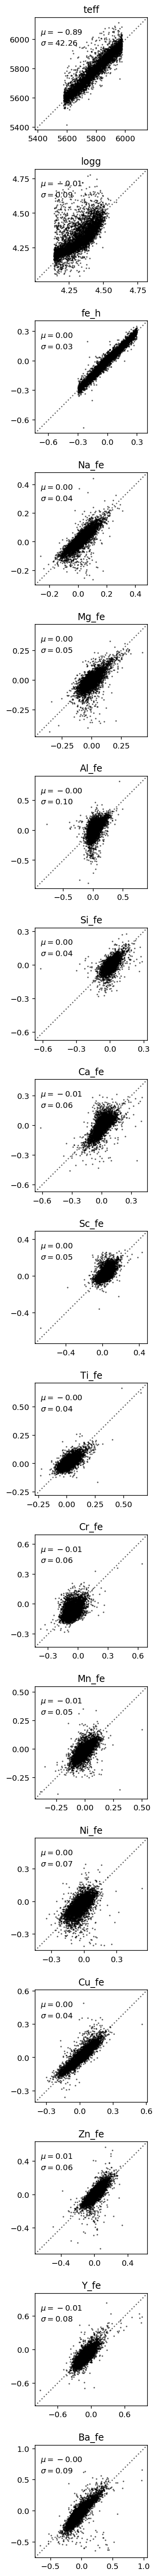

In [12]:
fig_comparison = tc.plot.one_to_one(model, test_labels,
#     latex_label_names=[
#         r"T_{\rm eff}",
#         r"\log{g}",
#         r"[{\rm Fe}/{\rm H}]",
#         r"[{\rm Al}/{\rm Fe}]",
#         r"[{\rm Y}/{\rm Fe}]",
#     ]
    )

In [14]:
model.write("models/solar_twin_training_set_16xfe_snr50_5144spec_17labels_11842pixels.model",overwrite=True)
#new_model = tc.CannonModel.read("models/solar_twin_training_set_16xfe_snr50_50spec_3labels.model")